# Proof-of-concept demo (geodesic assignment)

## First load data

In [75]:
from src.datasets.test import TestDataset
from src.utils import plot2
import matplotlib.pyplot as plt
import cv2


img = cv2.imread("images/test.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Load model

In [76]:
from src.model.build_sam_encoder import sam_encoder_model_registry
from src.model.smm import SMM

sam_enc_checkpoint = "weights/sam_vit_b_01ec64_encoder.pth"
model_type = "vit_b_encoder"

# load SAM encoder
device = "cpu"
sam_encoder = sam_encoder_model_registry[model_type](checkpoint=sam_enc_checkpoint)

# create SMM model
smm = SMM(sam_encoder)
smm.to(device=device)

SMM(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [77]:
embs = smm._forward_encoder(img)
print(embs.shape)



torch.Size([1, 256, 64, 64])


In [78]:
def compute_grad(x, normalize=True, eps=1e-8):
    # Compute gradients along H and W using finite differences
    grad_h = x[:, :, 1:, :] - x[:, :, :-1, :]
    grad_h = torch.nn.functional.pad(grad_h, (0, 0, 0, 1))
    
    grad_w = x[:, :, :, 1:] - x[:, :, :, :-1]
    grad_w = torch.nn.functional.pad(grad_w, (0, 1, 0, 0))
    
    grad_mag = torch.sqrt(grad_h**2 + grad_w**2)

    if normalize:
        # Normalize to 0..1 range
        max_val = grad_mag.amax(dim=(1,2,3), keepdim=True)  # per sample
        grad_mag = grad_mag / (max_val + eps)

    return grad_mag

def max_grad(x):
    grad_mag = compute_grad(x, normalize=True)
    collapsed = grad_mag.max(dim=1).values  # shape [B, H, W]
    return collapsed
    
def avg_grad(x):
    grad_mag = compute_grad(x, normalize=True)
    collapsed = grad_mag.mean(dim=1)  # shape [B, H, W]
    return collapsed

0.13980174 0.0


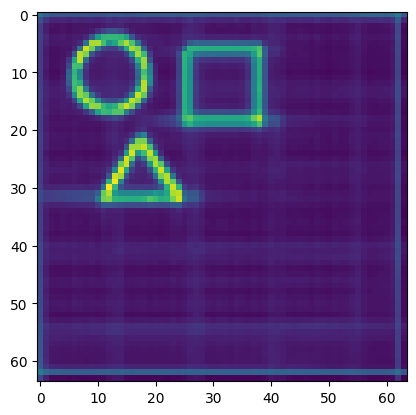

In [79]:
context_change = avg_grad(embs)
print(np.max(context_change[0].cpu().numpy()), np.min(context_change[0].cpu().numpy()))
plt.imshow(context_change[0].cpu().numpy())

1.0 0.0


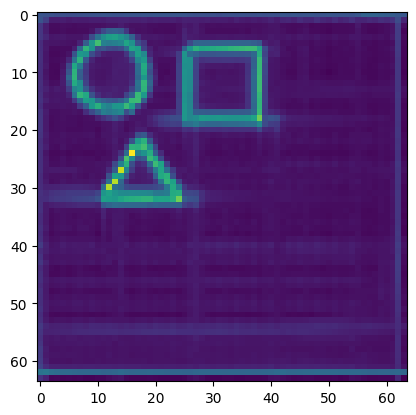

In [80]:
context_change = max_grad(embs)
print(np.max(context_change[0].cpu().numpy()), np.min(context_change[0].cpu().numpy()))
plt.imshow(context_change[0].cpu().numpy())

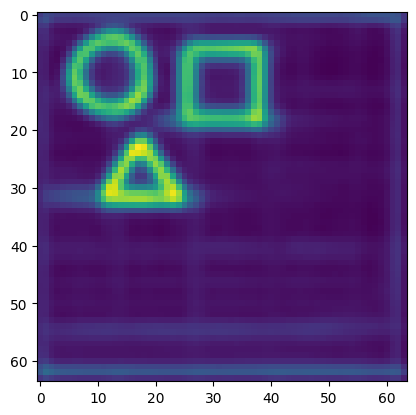

In [81]:
import torch.nn.functional as F

# --- Gaussian smoothing ---
def gaussian_kernel(kernel_size=5, sigma=1.0):
    """Creates a 2D Gaussian kernel."""
    ax = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / kernel.sum()
    return kernel


kernel_size = 5
sigma = 1.0
kernel = gaussian_kernel(kernel_size, sigma).unsqueeze(0).unsqueeze(0)  # shape [1,1,k,k]

# Apply Gaussian smoothing using conv2d
smoothed = F.conv2d(context_change, kernel, padding=kernel_size//2)


plt.imshow(smoothed[0].cpu().numpy())

torch.Size([1, 64, 64])
Level 0 shape: torch.Size([1, 1, 64, 64])
Level 1 shape: torch.Size([1, 1, 32, 32])
Level 2 shape: torch.Size([1, 1, 16, 16])
Level 3 shape: torch.Size([1, 1, 8, 8])
Level 4 shape: torch.Size([1, 1, 4, 4])


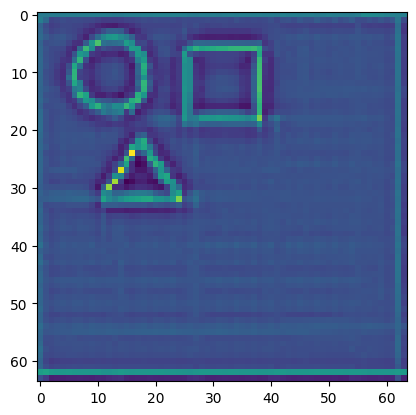

In [82]:
def conv_gaussian(img, kernel):
    return F.conv2d(img, kernel, padding=kernel.size(-1)//2)

def laplacian_pyramid(img, levels=4, kernel_size=5, sigma=1.0):
    kernel = gaussian_kernel(kernel_size, sigma).unsqueeze(0).unsqueeze(0).to(img.device)
    current = img
    pyramid = []
    
    for i in range(levels):
        # Gaussian smoothing
        smoothed = conv_gaussian(current, kernel)
        
        # Downsample (factor 2)
        down = F.interpolate(smoothed, scale_factor=0.5, mode='bilinear', align_corners=False)
        
        # Upsample back to current size
        up = F.interpolate(down, size=current.shape[-2:], mode='bilinear', align_corners=False)
        
        # Laplacian level = current - upsampled
        lap = current - up
        pyramid.append(lap)
        
        # Next level
        current = down
    
    # Last level (smallest Gaussian)
    pyramid.append(current)
    
    return pyramid

print(context_change.shape)
# Build Laplacian pyramid
pyramid = laplacian_pyramid(context_change.unsqueeze(0), levels=4)

# Print shapes
for i, level in enumerate(pyramid):
    print(f"Level {i} shape: {level.shape}")

plt.imshow(pyramid[0][0][0])

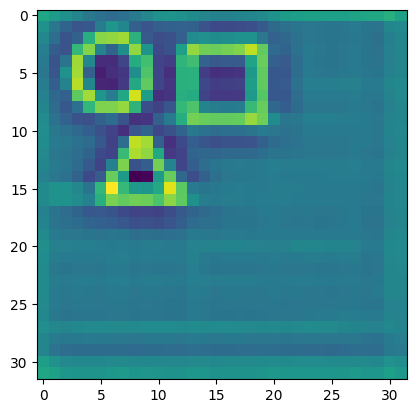

In [83]:

plt.imshow(pyramid[1][0][0])

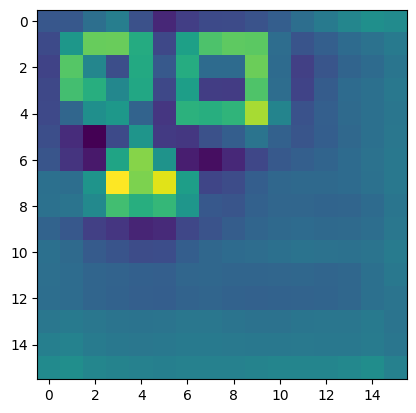

In [84]:

plt.imshow(pyramid[2][0][0])

In [85]:
import random
import math
from collections import Counter

num_agents = 4096
steps = 32
temperature = 0.0005  # smaller = more deterministic, larger = more random (0+eps - deterministic, 1-standard softmax, >>1 random)
merge_radius = 3    # cells within this distance are merged

grad_img = smoothed[0]
H,W = grad_img.shape[:2]

# Randomly initialize agent positions
agents = [(random.randint(0,H-1), random.randint(0,W-1)) for _ in range(num_agents)]
trajectories = {i: [pos] for i, pos in enumerate(agents)}

# 8-connected neighbors
neighbors = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,0), (0,1), (1,-1), (1,0), (1,1)]

# --- Simulation: stochastic agent movement ---
for step in range(steps):
    new_positions = []
    for i, (x, y) in enumerate(agents):
        # Gather candidate positions
        candidates = []
        grad_vals = []
        for dx, dy in neighbors:
            nx, ny = x+dx, y+dy
            if 0 <= nx < H and 0 <= ny < W:
                candidates.append((nx, ny))
                grad_vals.append(grad_img[nx, ny].item())
        
        # Softmax probabilities with temperature
        logits = torch.tensor([-v for v in grad_vals]) / temperature
        probs = torch.softmax(logits, dim=0).numpy()
        
        # Sample one position
        new_pos = random.choices(candidates, weights=probs, k=1)[0]
        new_positions.append(new_pos)
        trajectories[i].append(new_pos)
    
    agents = new_positions  # update agent positions

from collections import defaultdict
import math

# --- Post-hoc merging based on radius ---
# Initialize each agent with weight 1
agent_weights = {i: 1 for i in range(num_agents)}
merged_into = {}  # track which agent each merged agent joins

for i in range(num_agents):
    if i in merged_into:
        continue
    traj_i = trajectories[i]
    for j in range(i+1, num_agents):
        if j in merged_into:
            continue
        traj_j = trajectories[j]
        # Check if trajectories come within merge_radius at any timestep
        for pos_i, pos_j in zip(traj_i, traj_j):
            dist = math.sqrt((pos_i[0]-pos_j[0])**2 + (pos_i[1]-pos_j[1])**2)
            if dist <= merge_radius:
                # Merge j into i
                agent_weights[i] += agent_weights[j]  # accumulate weight
                merged_into[j] = i
                break

# --- Build final positions with weights ---
final_positions = []
weights = []

for i in range(num_agents):
    # Only include surviving agents (not merged into others)
    if i not in merged_into:
        pos = trajectories[i][-1]  # final position
        w = agent_weights[i]       # accumulated weight
        final_positions.append(pos)
        weights.append(w)

print("Unique final positions:", final_positions)
print("Weights:", weights)
print(len(final_positions))

Unique final positions: [(10, 11), (11, 31), (51, 43), (19, 6), (24, 31), (44, 50), (24, 24), (57, 63), (3, 44), (24, 6), (52, 36), (48, 3), (35, 50), (59, 4), (48, 10), (7, 3), (3, 6), (6, 50), (52, 4), (35, 57), (24, 57), (10, 57), (63, 34), (48, 22), (28, 17), (16, 52), (58, 59), (51, 18), (58, 44), (36, 63), (37, 21), (44, 10), (44, 22), (37, 44), (37, 3), (19, 63), (59, 33), (44, 57), (24, 63), (63, 52), (44, 35), (20, 58), (38, 10), (63, 8), (59, 10), (35, 36), (44, 43), (37, 30), (44, 31), (24, 52), (20, 15), (29, 35), (48, 38), (15, 21), (58, 16), (3, 36), (3, 22), (10, 43), (10, 22), (58, 51), (44, 16), (52, 63), (15, 44), (10, 50), (63, 58), (48, 50), (63, 0), (46, 63), (63, 23), (9, 63), (37, 17), (24, 35), (48, 30), (52, 10), (28, 30), (58, 36), (0, 0), (28, 0), (16, 58), (44, 4), (63, 63), (63, 44)]
Weights: [101, 138, 66, 84, 175, 58, 85, 28, 76, 171, 96, 63, 163, 88, 61, 65, 67, 76, 17, 122, 61, 109, 45, 73, 54, 53, 65, 37, 41, 14, 113, 23, 38, 27, 75, 22, 66, 99, 5, 15,

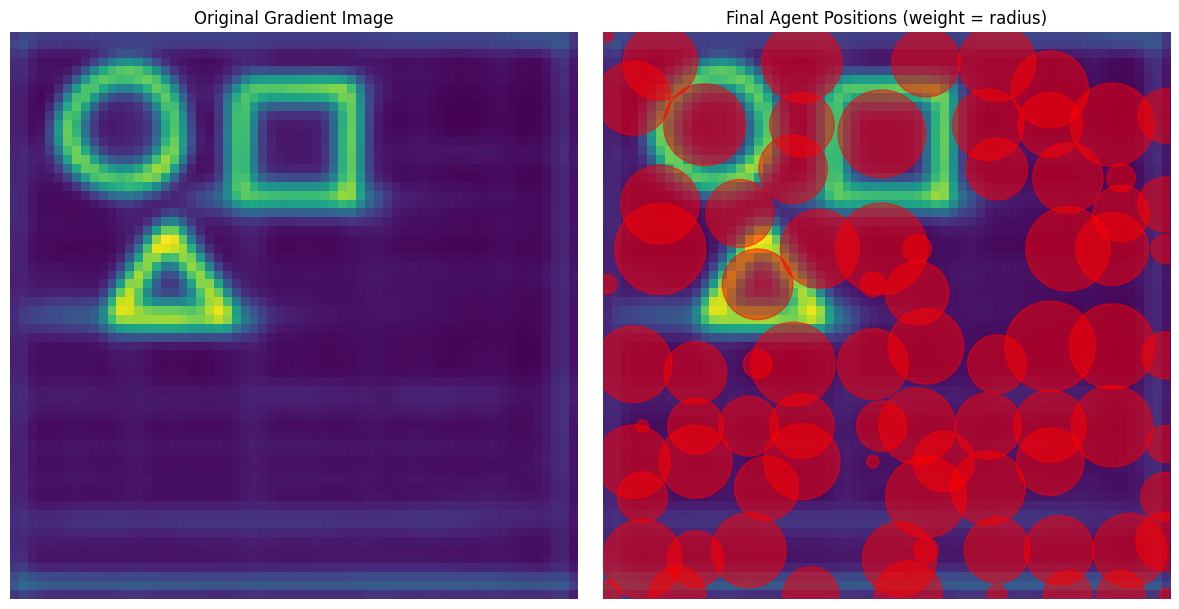

In [86]:
grad_np = grad_img.numpy()

# Set up figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Left: original gradient image ---
axes[0].imshow(grad_np, cmap='viridis')
axes[0].set_title("Original Gradient Image")
axes[0].axis('off')

# --- Right: final positions with weight as radius ---
axes[1].imshow(grad_np, cmap='viridis')  # optional: show gradient as background
axes[1].set_title("Final Agent Positions (weight = radius)")
axes[1].axis('off')

# Draw circles for each final position
for (y, x), w in zip(final_positions, weights):
    circle = plt.Circle((x, y), radius=math.log(w), color='red', alpha=0.5)
    axes[1].add_patch(circle)

plt.tight_layout()
plt.show()

In [87]:
import networkx as nx
import numpy as np

# final_positions: [(y, x), ...]
# grad_img: [H, W]

radius = 30
grad_thresh = 0.2

print(np.max(grad_np), np.min(grad_np))
G = nx.Graph()
for i, p1 in enumerate(final_positions):
    G.add_node(i)
    for j, p2 in enumerate(final_positions):
        if j <= i: 
            continue
        # Euclidean distance
        dist = np.linalg.norm(np.array(p1) - np.array(p2))
        if dist < radius:
            # Sample gradient values along the line between p1 and p2
            num_samples = int(dist * 2)
            ys = np.linspace(p1[0], p2[0], num_samples).astype(int)
            xs = np.linspace(p1[1], p2[1], num_samples).astype(int)
            grad_vals = grad_img[ys, xs]
            
            if grad_vals.max() < grad_thresh:
                G.add_edge(i, j)

# Connected components = merged clusters
clusters = list(nx.connected_components(G))
print(clusters)
print(len(clusters))

0.5401725 0.024484968
[{0}, {1}, {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81}, {24}]
4


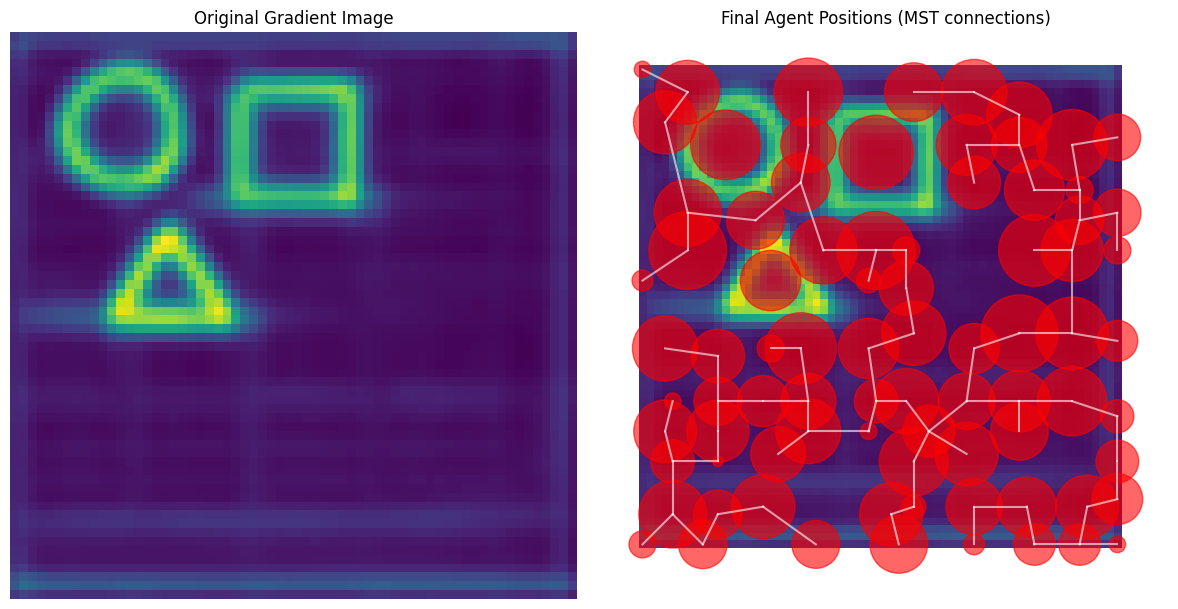

In [88]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np

grad_np = grad_img.numpy()

# clusters = list of sets of agent indices
# final_positions = [(y, x), ...]
# weights = [w1, w2, ...]

# Set up figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Left: original gradient image ---
axes[0].imshow(grad_np, cmap='viridis')
axes[0].set_title("Original Gradient Image")
axes[0].axis('off')

# --- Right: final positions with MST connections ---
axes[1].imshow(grad_np, cmap='viridis')
axes[1].set_title("Final Agent Positions (MST connections)")
axes[1].axis('off')

for cluster in clusters:
    cluster = list(cluster)
    if len(cluster) <= 1:
        continue

    # Build a complete graph of distances
    G = nx.Graph()
    for i in range(len(cluster)):
        for j in range(i+1, len(cluster)):
            p1 = np.array(final_positions[cluster[i]])
            p2 = np.array(final_positions[cluster[j]])
            dist = np.linalg.norm(p1 - p2)
            G.add_edge(i, j, weight=dist)

    # Compute MST
    T = nx.minimum_spanning_tree(G)

    # Draw edges of MST
    for (i, j) in T.edges():
        p1 = final_positions[cluster[i]]
        p2 = final_positions[cluster[j]]
        axes[1].plot([p1[1], p2[1]], [p1[0], p2[0]], color='white', alpha=0.6)

# Draw circles (final positions) on top
for (y, x), w in zip(final_positions, weights):
    circle = plt.Circle((x, y), radius=math.log(w+1), color='red', alpha=0.6)
    axes[1].add_patch(circle)

plt.tight_layout()
plt.show()
